<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
import platform
print(platform.system())

Linux


In [3]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) DATA PRE-PROCESSING

a) Load in labels + image file paths

b) combine them into one dataframe

c) EDA - spotted and removed erroneous label (speed = 1.42...)

- `cleaned_df` is the cleaned df with a) b) c) completed

d) convert images to numerical RGB feature maps - ML algorithms only understand numerical data

e) Splitting data into training and validation sets

f) data augmentation applied to training set

### 1a) load in labels + image file paths

In [ ]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)

labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [7]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data' # ben hpc file path (mlis2 cluster)
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path

image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [8]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [9]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/5.png


### 1b) Combine labels and image file paths into one dataframe

In [10]:
merged_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
merged_df['speed'] = merged_df['speed'].round(6) # to get rid of floating point errors

In [12]:
merged_df.tail()

,angle,speed,image_file_paths
image_id,,,
13794,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13794.png
13795,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13795.png
13796,0.5625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13796.png
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13798.png


The cell below shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the 5 missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

In [13]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3143.png


### 1c) EDA

In [14]:
merged_df.value_counts('speed').sort_index()

speed
0.000000     3390
1.000000    10402
1.428571        1
Name: count, dtype: int64

note: imbalance datset

identifying the row with the erroneous speed value

In [16]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,
3884,0.4375,1.428571,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3884.png


we want to remove this row

In [18]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,
3882,0.5625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3882.png
3883,0.3750,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3883.png
3885,0.0000,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3885.png
3886,0.7500,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3886.png


### 1d) convert images to numerical RGB feature maps

In [19]:
def process_image(image_path, label, resized_shape=(320, 240)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

2025-04-29 14:34:09.993909: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


lets check and see if what we have done works

In [20]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

2025-04-29 14:34:37.423555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2562 of 13792
2025-04-29 14:34:47.437148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 5398 of 13792
2025-04-29 14:34:57.425364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8720 of 13792
2025-04-29 14:35:07.566025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 11939 of 13792
2025-04-29 14:35:17.430739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 13417 of 13792
2025-04-29 14:35:19.073748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


(32, 320, 240, 3) (32,)


### 1e) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [21]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

In [22]:
print(f"Train size: {train_size}, Test size: {dataset_size - train_size}")

Train size: 344, Test size: 87


### 1f) Speed classification model's version: Data Augmentation applied to training set

- Random Horizontal Flip
- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Vertical Flip

In [23]:
#only performing augmentation on training data as want validation/test data to reflect kaggle test set
seed = (6,9)
train_dataset = train_dataset.map(
      lambda image, label: (tf.image.stateless_random_flip_left_right(image,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_brightness(image, 0.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_contrast(image, 0.8, 1.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_hue(image, 0.2, seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_saturation(image, 0.8, 1.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_flip_up_down(image,seed),label)
)

checking to see if whats been done was successful or needs debugging

image shape:  (320, 240, 3)
label: 0
image shape:  (320, 240, 3)
label: 0
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 0
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 1


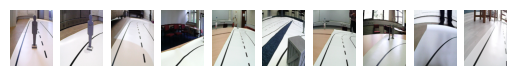

In [27]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) Model Building

### 2a) Set up model architecture

- MobileNetV2 to learn lower level features
- global average pooling layer
- drop out layer
- dense layer with sigmoid activation

In [28]:
dropoutrate = 0.2
num_classes = 2
input_shape = (256,256,3)

mbnet =  tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [ ]:
with tf.GradientTape() as tape:
  tape.reset() #this resets the gradient tape

In [ ]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [ ]:
niter = 20

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image_batch, label_batch in train_dataset:
      #for image, label in zip(image_batch, label_batch):
        #print(image)
        #print(label)
        #print(image.shape, label.shape)

        loss, acc = train_step(model, image_batch, tf.one_hot(tf.cast(label_batch, dtype=tf.int32), depth=2)) #run training


    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)
'we should probably switch to balanced accuracy as eval method due to unbalanced data'
#commented out validation for now as it prints for each batch not each epoch massively slowwing process
'''
    if it % 50 == 0: #log validation metrics
      for val_image, val_label in validation_dataset:
        val_pred = model(val_image)
        val_int=tf.cast(val_label, dtype=tf.int32)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_int,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_int,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)
'''

In [ ]:
'''
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
        plt.show()
'''

In [ ]:
model.save_weights('/content/drive/MyDrive/machine-learning-in-science-ii-2025/car_frozen.weights.h5')

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

In [ ]:
dropoutrate = dropoutrate
num_classes = num_classes
input_shape = input_shape

mbnet =  tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build()

mbnet.trainable = False

model.summary() # print the model

In [ ]:
model.load_weights('/content/drive/MyDrive/machine-learning-in-science-ii-2025/car_frozen.weights.h5')

In [ ]:
mbnet.trainable = True
model.summary()

In [ ]:
LR = 0.0001
optimizer = tf.optimizers.Adam(LR) #adam optimiser


In [ ]:
niter = 20

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train_dataset:
        loss, acc = train_step(model, image_batch, tf.one_hot(tf.cast(label_batch, dtype=tf.int32), depth=2))

    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)
'''
    if it % 50 == 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)
'''

In [ ]:
model.save_weights('/content/drive/MyDrive/machine-learning-in-science-ii-2025/car_unfrozen.weights.h5')

In [ ]:
image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/test_data/test_data'
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

In [ ]:
def process_image_no_label(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, (128, 128))  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image
test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


In [ ]:
predictions = model.predict(test_dataset)

In [ ]:
predictions_df.head()

In [ ]:
predictions_df[[0,1]] > 0.5

In [ ]:
predictions_df = pd.DataFrame(predictions)

In [ ]:
predictions_df[predictions_df[[0,1]] > 0.5] = 1
predictions_df[predictions_df[[0,1]] < 0.5] = 0

In [ ]:
predictions_df[0]

In [ ]:
predictions_df[0].value_counts()